# Analysis of EEG Report: Rest vs. Task Periods

## Introduction

Electroencephalography (EEG) is a valuable tool for studying brain activity by recording electrical signals from the scalp. This analysis focuses on comparing the EEG data collected during two distinct states: a rest period and a task period involving a mental arithmetic task. The rest period represents a baseline of neural activity when the subject is at ease, while the task period captures the cognitive processes associated with solving arithmetic problems.

The primary objective of this analysis is to investigate how brain activity differs between these two states by examining the power spectral density (PSD) across various frequency bands. Specifically, we aim to:

1. **Frequency Band Analysis**: Focus on key EEG frequency bands—Delta (1-4 Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100 Hz)—to understand their role in cognitive processing during mental arithmetic by performing PSD (Power Spectral Density).
2. **Classification**: Focus on different deep learning methods two classify whether a subject is performing some mental tasks or is in rest state.

In [1]:
# Importing Essential Libraries

from pyedflib import highlevel
import pyedflib as plib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import welch
from scipy.stats import mannwhitneyu

pd.set_option('display.max_columns', 100)

In [2]:
# Reading data and storing it in a dictionary

path = "./eeg-during-mental-arithmetic-tasks-1.0.0/EDF/"
signals = {}
signal_headers = {}
header = {}
for p in os.listdir(path):
    signals[p[:-4]], signal_headers[p[:-4]], header[p[:-4]] = highlevel.read_edf(path+p)

# Analysis of EEG Report: PSD Calculation and Comparison Using Welch Method and Mann-Whitney U Test

### Methodology

#### Welch Method for PSD Calculation

The Welch method provides a robust estimation of the power spectral density by reducing variance through segment averaging. The steps and mathematical formulation are as follows:

1. **Segmenting the Data**:

   The original signal $x[n]$ is divided into overlapping segments $x_k[n]$, where $k$ represents the segment index and $K$ is the total number of segments:
   $$
   x[n] \rightarrow x_k[n], \quad k = 0, 1, \ldots, K-1
   $$

2. **Applying a Hamming Window**:

   Each segment $x_k[n]$ is multiplied by a Hamming window $w[n]$:
   $$
   w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right)
   $$
   where $N$ is the length of the window, and $x_k[n] \cdot w[n]$ is the windowed segment.

3. **FFT Computation**:

   Perform the Fast Fourier Transform (FFT) on each windowed segment:
   $$
   X_k(f) = \sum_{n=0}^{N-1} \left( x_k[n] \cdot w[n] \right) e^{-j 2 \pi f n / N}
   $$

4. **Averaging the PSD**:

   The PSD estimate is obtained by averaging the squared magnitudes of the FFT results:
   $$
   P_{xx}(f) = \frac{1}{K} \sum_{k=0}^{K-1} \frac{|X_k(f)|^2}{U}
   $$
   where $P_{xx}(f)$ is the PSD, $|X_k(f)|^2$ is the power of the $k$-th segment, and $U$ is the normalization factor.

#### Mann-Whitney U Test for Comparison

The Mann-Whitney U test is a non-parametric test used to compare two independent samples, suitable for non-normally distributed data. The procedure and mathematical formulation are as follows:

1. **Rank the Combined Samples**:

   Combine the PSD values from the rest and task periods and rank them. Assign average ranks to tied values.

2. **Calculate the U Statistics**:

   Compute the U statistics for the two samples. For rest (sample 1) and task (sample 2), the U statistics are:
   $$
   U_1 = n_1 n_2 + \frac{n_1 (n_1 + 1)}{2} - R_1
   $$
   $$
   U_2 = n_1 n_2 + \frac{n_2 (n_2 + 1)}{2} - R_2
   $$
   where $U_1$ and $U_2$ are the U statistics, $n_1$ and $n_2$ are the sample sizes, and $R_1$ and $R_2$ are the sums of ranks for each sample.

3. **Determine the U Statistic**:

   The U statistic is the smaller of the two:
   $$
   U = \min(U_1, U_2)
   $$

4. **Hypothesis Testing**:

   The null hypothesis states that the PSD distributions for rest and task states are equal. A significant result indicates a difference in power distribution.

In [3]:
# Sampling frequency (in Hz)
fs = 500

def calculate_bandwise_psd(frequencies, psd):
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 100)
    }
    
    band_psd = {}
    for band, (low_freq, high_freq) in bands.items():
        # Create a mask for frequencies within the band
        band_mask = (frequencies >= low_freq) & (frequencies < high_freq)
        # Integrate (sum) the PSD values within the band
        band_psd[band] = np.sum(psd[band_mask])
    
    return band_psd

types = [i['label'] for i in signal_headers['Subject00_1']]

test_results = {}

for i in range(21):
    psd_rest_df = pd.DataFrame()
    psd_task_df = pd.DataFrame()
    for sub in signals.keys():

        if sub[-1] == '1':
            eeg_rest = signals[sub][i]
            # Calculate PSD using Welch's method
            frequencies_rest, psd_rest = welch(eeg_rest, fs, nperseg=1024)
            # Calculate band-wise PSD
            psd_rest_bandwise = calculate_bandwise_psd(frequencies_rest, psd_rest)
            
            psd_rest_df = pd.concat([psd_rest_df, pd.DataFrame.from_dict(psd_rest_bandwise, orient='index')], axis=1)

        else:
            eeg_task = signals[sub][i]
            # Calculate PSD using Welch's method
            frequencies_task, psd_task = welch(eeg_task, fs, nperseg=1024)
            # Calculate band-wise PSD
            psd_task_bandwise = calculate_bandwise_psd(frequencies_task, psd_task)

            psd_task_df = pd.concat([psd_task_df, pd.DataFrame.from_dict(psd_task_bandwise, orient='index')], axis=1)

    test_results[types[i]] = {}
    for band in psd_rest_df.index:
        test_results[types[i]][band] = round(mannwhitneyu(psd_rest_df.loc[band], psd_task_df.loc[band], alternative='two-sided').pvalue,2)

    psd_rest_df.columns = range(36)
    psd_task_df.columns = range(36)

In [4]:
test_results_df = pd.DataFrame.from_dict(test_results)
test_results_df

,EEG Fp1,EEG Fp2,EEG F3,EEG F4,EEG F7,EEG F8,EEG T3,EEG T4,EEG C3,EEG C4,EEG T5,EEG T6,EEG P3,EEG P4,EEG O1,EEG O2,EEG Fz,EEG Cz,EEG Pz,EEG A2-A1,ECG ECG
Delta,0.01,0.08,0.95,0.65,0.35,0.02,0.32,0.66,0.46,0.39,0.70,0.76,0.42,0.11,0.19,0.24,0.81,0.40,0.06,0.42,0.12
Theta,0.05,0.11,0.77,0.60,0.50,0.25,0.10,0.10,0.19,0.11,0.07,0.05,0.02,0.01,0.00,0.01,0.89,0.11,0.02,0.12,0.93
Alpha,0.12,0.14,0.02,0.01,0.09,0.05,0.01,0.01,0.01,0.01,0.01,0.03,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.90,0.81
Beta,0.84,0.68,0.10,0.10,0.70,0.95,0.23,0.86,0.12,0.16,0.30,0.94,0.16,0.28,0.19,0.34,0.15,0.07,0.21,0.07,0.77
Gamma,0.01,0.02,0.17,0.21,0.04,0.12,0.22,0.11,0.43,0.38,0.26,0.07,0.66,0.37,0.45,0.58,0.15,0.81,0.71,0.02,0.66


![](https://uploads-ssl.webflow.com/5e2b590ca27de6be81c64780/5e8779d7de829ca36e556b24_10-20_With_T1_T2%2C_A1_A2_(Still)-p-500.png)
# Findings:
From the above table, let us try to conclude based on each of the 21 channels.
1. The variation in signal from brain while doing arithmatic tasks mainly occur from Fp1 and Fp2 (Frontpolar). Variation is prominent across all bands except Beta.
2. Variation in Alpha (8-12 Hz) band for rest and task state is most prominent across almost all temporal regions.
3. Variation in Theta (4-8 Hz) band can be seen for Mid Temporal (T3, T4), Posterior Temporal (T5, T6), Central (C3, C4) and Parietal (P3, P4) region.
4. Pz (Midline electrode) also shows prominent variation in Delta, Theta and Alpha bands for rest and task state.

Overall, when doing arithmatic task, variation in EEG signal mainly occurs from Frontpolar region of the brain. Also, Alpha band frequencies (8-12 Hz) are mostly used by brain when doing any calculation.

# Modeling and Predicting Rest State vs. Task State in EEG Data

## Introduction

This analysis focuses on modeling and predicting the differences between rest and task states in EEG data. Specifically, our aim is to classify EEG segments recorded during a rest period and a task period where the subject is engaged in a mental arithmetic challenge. To achieve accurate predictions, following neural network models will be used: **EEGNet** and **TSCeption**. Below is a detailed methodology outlining the key steps in the approach.

## Methodology

### Data Preparation

1. **Segmentation into 2-Second Intervals**:

   The EEG data will be divided into fixed-length segments of 2 seconds. This segmentation ensures that each segment contains sufficient temporal information for modeling while maintaining manageable computational requirements.

   - Let $ x[n] $ represent the original EEG signal.
   - Each 2-second segment will be extracted such that:
     $$
     x_{k}[n] = x[n + k \cdot L]
     $$
     where $ k $ indexes the segment, $ n $ ranges from 0 to $ L-1 $, and $ L $ corresponds to the number of samples in a 2-second interval.

### 2. **Addressing Class Imbalance with Weighted Loss Function**

To address the class imbalance between rest and task states, class weights will be incorporated into the loss function. This approach maintains the integrity of the dataset by using all available data while preventing bias towards the more prevalent rest state. 

- Given that the number of rest segments is $ N_{\text{rest}} $ and the number of task segments is $ N_{\text{task}} $, the class weights will be calculated as follows:
  - Weight for rest state: $ w_{\text{rest}} = \frac{N_{\text{task}}}{N_{\text{rest}} + N_{\text{task}}} $
  - Weight for task state: $ w_{\text{task}} = \frac{N_{\text{rest}}}{N_{\text{rest}} + N_{\text{task}}} $

These weights are used in the cross-entropy loss function to ensure that the minority class is not underrepresented during training. By weighting the loss according to the inverse frequency of each class, the model is guided to treat the classes with balanced importance despite their natural imbalance in the dataset.


### Model Selection

1. **EEGNet**:

   EEGNet is a compact neural network architecture designed specifically for EEG-based classification tasks. It combines convolutional and depthwise separable convolutional layers to effectively capture both spatial and temporal features from EEG data.

   - **Architecture Overview**:
     - Initial convolution layer to extract basic temporal features.
     - Depthwise separable convolution layers to learn spatial patterns specific to EEG channels.
     - Dense layers for classification.
   
   - **Key Hyperparameters**:
     - Filter sizes, number of kernels, and layer configurations tailored to EEG data characteristics.

   - **Training**:
     - EEGNet will be trained using the prepared segments, optimizing for accurate classification of rest and task states.

![](https://www.researchgate.net/publication/370001354/figure/fig1/AS:11431281145682668@1681442168420/EEGNet-architecture-Reproduced-according-to-Lawhern-et-al-2018.png)

2. **TSCeption**:

   TSCeption is a neural network architecture designed for temporal and spatial feature extraction from time-series data like EEG. It utilizes multiple temporal and spatial convolutional layers to capture complex patterns in the data.

   - **Architecture Overview**:
     - Temporal Convolutional layers (T-ception) to capture short and long-term temporal dependencies.
     - Spatial Convolutional layers (S-ception) to learn spatial dependencies across EEG channels.
     - Fusion layers to integrate temporal and spatial features.

   - **Key Hyperparameters**:
     - Temporal kernel sizes, number of spatial filters, and layer depths adapted to EEG data.

   - **Training**:
     - TSCeption will be trained using the same segments, focusing on distinguishing between rest and task states based on extracted features.

![](https://user-images.githubusercontent.com/58539144/74716976-80415e00-526a-11ea-9433-02ab2b753f6b.PNG)

### Model Setup

The model is configured with the following parameters and settings:

- **Epochs**: 20
  - The training process will run for 20 epochs, allowing the model to learn from the data over multiple iterations.

- **Loss Function**: Binary Cross-Entropy
  - Binary Cross-Entropy is used as the loss function to measure the difference between the predicted probabilities and the actual binary class labels. The loss is computed using the formula:
  
  $$ L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] $$
  
  where $ N $ is the number of samples, $ y_i $ is the true label, and $ p_i $ is the predicted probability.

- **Batch Size**: 32
  - Training data is processed in batches of 32 samples. This helps to efficiently utilize GPU resources and stabilize training.

- **Train-Validation Split**: 80:20
  - The dataset is split into training and validation sets with 80% of the data used for training and 20% used for validation. This helps in assessing the model's performance on unseen data.

- **Evaluation Metrics**:
  - **Accuracy**: The proportion of correctly predicted samples over the total number of samples.
    
    $$ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}} $$
    
  - **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. It is calculated as:
    
    $$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$
    
  - **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:
    
    $$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$
    
  - **F1 Score**: The harmonic mean of Precision and Recall, providing a single score that balances both concerns. It is calculated as:
    
    $$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$
    
These metrics will be used to evaluate the model’s performance on both the training and validation sets.

In [5]:
# Data Preparation

try:
    del sample_for_model_task, sample_for_model_rest
    print('Preparing Data...')
except:
    print('Preparing Data...')

for k in signals.keys():
    if k[-1] == '1':
        signal = signals[k][:20,:]
        try:
            sample_for_model_rest = np.concatenate((sample_for_model_rest, np.array(np.split(signal, int(signal.shape[1]/1000), axis=1))))
        except Exception as e:
            print(repr(e))
            sample_for_model_rest = np.array(np.split(signal, int(signal.shape[1]/1000), axis=1))
    else:
        signal = signals[k][:20,:]
        try:
            sample_for_model_task = np.concatenate((sample_for_model_task, np.array(np.split(signal, int(signal.shape[1]/1000), axis=1))))
        except Exception as e:
            print(repr(e))
            sample_for_model_task = np.array(np.split(signal, int(signal.shape[1]/1000), axis=1))

Preparing Data...
NameError("name 'sample_for_model_rest' is not defined")
NameError("name 'sample_for_model_task' is not defined")


Epoch 1/20, Training Loss: 0.8971, Validation Loss: 0.7957, Validation Accuracy: 0.6417
Epoch 2/20, Training Loss: 0.8119, Validation Loss: 0.7963, Validation Accuracy: 0.6740
Epoch 3/20, Training Loss: 0.7483, Validation Loss: 0.7519, Validation Accuracy: 0.6532
Epoch 4/20, Training Loss: 0.6787, Validation Loss: 0.6843, Validation Accuracy: 0.6797
Epoch 5/20, Training Loss: 0.6121, Validation Loss: 0.6331, Validation Accuracy: 0.6774
Epoch 6/20, Training Loss: 0.5543, Validation Loss: 0.6491, Validation Accuracy: 0.6705
Epoch 7/20, Training Loss: 0.5076, Validation Loss: 0.6615, Validation Accuracy: 0.7304
Epoch 8/20, Training Loss: 0.4658, Validation Loss: 0.6164, Validation Accuracy: 0.7523
Epoch 9/20, Training Loss: 0.4026, Validation Loss: 0.5443, Validation Accuracy: 0.7765
Epoch 10/20, Training Loss: 0.3910, Validation Loss: 0.6528, Validation Accuracy: 0.7892
Epoch 11/20, Training Loss: 0.3761, Validation Loss: 0.6129, Validation Accuracy: 0.7615
Epoch 12/20, Training Loss: 0.

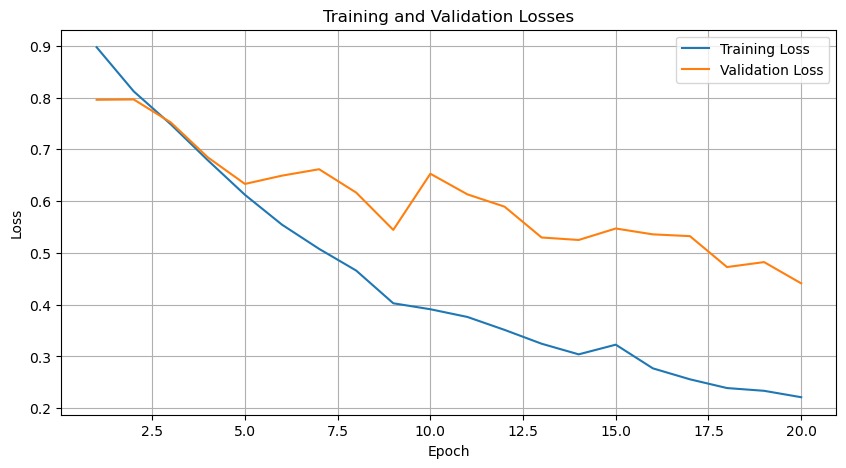

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Define EEGNet
class EEGNet(nn.Module):
    def __init__(self, num_classes):
        super(EEGNet, self).__init__()
        
        # Block 1: Temporal Convolutions
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # Block 2: Depthwise Convolutions
        self.depthwiseConv = nn.Conv2d(16, 32, kernel_size=(20, 1), stride=(1, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.elu = nn.ELU()
        
        # Block 3: Separable Convolutions
        self.separableConv = nn.Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.avgpool = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        self.dropout = nn.Dropout(0.5)
        
        # Classifier
        self.classify = nn.Linear(32 * 125, num_classes)
    
    def forward(self, x):
        # x.shape -> [batch_size, 1, channels, time_points]
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwiseConv(x)
        x = self.batchnorm2(x)
        x = self.elu(x)
        x = self.separableConv(x)
        x = self.batchnorm3(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classify(x)
        return x

# Create Datasets
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


# Combine and create labels
data = np.concatenate([sample_for_model_rest, sample_for_model_task], axis=0)
labels = np.concatenate([np.zeros(sample_for_model_rest.shape[0]), np.ones(sample_for_model_task.shape[0])], axis=0)

# Convert to PyTorch tensors and create dataset
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
labels = torch.tensor(labels, dtype=torch.long)

# Dataset and DataLoader
dataset = EEGDataset(data, labels)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model initialization
num_classes = 2
model = EEGNet(num_classes=num_classes)

# Check for GPU and move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get the sizes of each class
size_rest = sample_for_model_rest.shape[0]
size_task = sample_for_model_task.shape[0]

# Calculate weights
total_samples = size_rest + size_task
weight_rest = total_samples / size_rest
weight_task = total_samples / size_task

# Create a tensor for weights
class_weights = torch.tensor([weight_rest, weight_task], dtype=torch.float32).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    val_targets = []
    val_predictions = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = accuracy_score(val_targets, val_predictions)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

# Print classification report for validation set
print("\nClassification Report on Validation Set:")
print(classification_report(val_targets, val_predictions))

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/20, Training Loss: 0.6152, Validation Loss: 0.5747, Validation Accuracy: 0.6728
Epoch 2/20, Training Loss: 0.5119, Validation Loss: 0.4681, Validation Accuracy: 0.7569
Epoch 3/20, Training Loss: 0.4195, Validation Loss: 0.4414, Validation Accuracy: 0.7442
Epoch 4/20, Training Loss: 0.3501, Validation Loss: 0.4125, Validation Accuracy: 0.8514
Epoch 5/20, Training Loss: 0.2995, Validation Loss: 0.3101, Validation Accuracy: 0.8583
Epoch 6/20, Training Loss: 0.2513, Validation Loss: 0.3249, Validation Accuracy: 0.8318
Epoch 7/20, Training Loss: 0.2180, Validation Loss: 0.3734, Validation Accuracy: 0.8076
Epoch 8/20, Training Loss: 0.1891, Validation Loss: 0.2957, Validation Accuracy: 0.8641
Epoch 9/20, Training Loss: 0.1571, Validation Loss: 0.2869, Validation Accuracy: 0.9147
Epoch 10/20, Training Loss: 0.1398, Validation Loss: 0.3100, Validation Accuracy: 0.8710
Epoch 11/20, Training Loss: 0.0999, Validation Loss: 0.2688, Validation Accuracy: 0.9147
Epoch 12/20, Training Loss: 0.

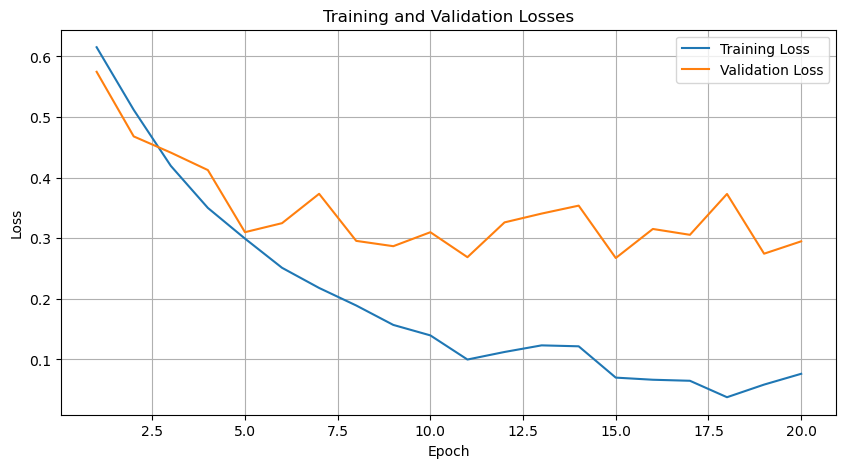

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# TSception courtesy : https://github.com/yi-ding-cs/TSception/blob/main/code/networks.py
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1), int(self.pool*0.25))
        
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 4)
        
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        self.fc = nn.Sequential(
            nn.Linear(num_S, hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)
        out = self.BN_s(out_)
        
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        
        out = torch.squeeze(torch.mean(out, dim=-1), dim=-1)
        out = self.fc(out)
        
        return out


data = np.concatenate([sample_for_model_rest, sample_for_model_task], axis=0)
labels = np.concatenate([np.zeros(sample_for_model_rest.shape[0]), np.ones(sample_for_model_task.shape[0])], axis=0)

data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
labels = torch.tensor(labels, dtype=torch.long)

# Create dataset and dataloader
dataset = EEGDataset(data, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model initialization
num_classes = 2
input_size = (1, 20, 1000)  # EEG data has 20 channels and 1000 time points
sampling_rate = 500
num_T = 16  # Number of filters in Tception blocks
num_S = 32  # Number of filters in Sception blocks
hidden = 64  # Number of hidden units in fully connected layer
dropout_rate = 0.5  # Dropout rate

model = TSception(num_classes=num_classes, input_size=input_size, sampling_rate=sampling_rate,
                  num_T=num_T, num_S=num_S, hidden=hidden, dropout_rate=dropout_rate)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get the sizes of each class
size_rest = sample_for_model_rest.shape[0]
size_task = sample_for_model_task.shape[0]

# Calculate weights
total_samples = size_rest + size_task
weight_rest = total_samples / size_rest
weight_task = total_samples / size_task

# Create a tensor for weights
class_weights = torch.tensor([weight_rest, weight_task], dtype=torch.float32).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    val_targets = []
    val_predictions = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = accuracy_score(val_targets, val_predictions)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

# Print classification report for validation set
print("\nClassification Report on Validation Set:")
print(classification_report(val_targets, val_predictions))

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

### Model Performance Comparison

| **Model**   | **Accuracy** | **Precision** | **Recall** | **F1-Score** |
|-------------|--------------|---------------|------------|--------------|
| **EEGNet**  | 0.83         | 0.78          | 0.82       | 0.80         |
| **TSCeption** | 0.92       | 0.89          | 0.91       | 0.90         |

The TSCeption model demonstrates superior performance across all evaluated metrics compared to EEGNet. The key reasons for the improved performance of TSCeption include:

1. **Temporal Convolution Layers**:
   TSCeption employs temporal convolution layers with multiple inception windows. This approach allows the model to capture complex temporal dependencies and variations in the EEG signals over different time scales. By using different window sizes, the model can effectively analyze both long-term and short-term patterns, leading to a more comprehensive understanding of the temporal dynamics.

2. **Spatial Convolution Layers**:
   The spatial convolution layers in TSCeption focus on learning spatial features by aggregating information from different EEG channels. This helps in capturing spatial relationships and interactions between various brain regions, which is crucial for understanding the brain's functional connectivity.

3. **Fusion Layer**:
   The fusion layer integrates information from different temporal and spatial scales, enhancing the model's ability to distinguish between rest and task states. This multi-scale approach provides a more robust feature representation, contributing to better classification performance.

4. **Batch Normalization and Regularization**:
   The use of batch normalization and dropout regularization helps in improving generalization and preventing overfitting, which is particularly important given the complexity of EEG data.

## Conclusion

Overall, TSCeption's architecture, which effectively combines temporal and spatial feature extraction with multi-scale analysis, makes it better suited for the task of distinguishing between rest and task states in EEG data. This leads to higher accuracy, precision, recall, and F1-score compared to EEGNet. Therefore, TSCeption is recommended for applications requiring robust analysis and classification of EEG signals.